# Whole cell data analysis

In [1]:
# Imports

## General 
from tqdm import tqdm
import sys 
sys.path.append("..")
from RNN_helpers import *
from IPython.display import display, Markdown
import datetime as dt
import pprint as pp

## Math
import numpy as np
import scipy as sp
import scipy.stats as sps

## Data 
import xarray as xr
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pyabf
from sklearn.metrics import r2_score

## Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

## Configuration
import warnings
warnings.filterwarnings('ignore')

/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:156: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if case is 'whole_trial':
/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:164: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif case is 'stim_choice_period':
/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:172: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif case is 'whole_trial_pre':
/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:181: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif case is 'first_second':
/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:190: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif case is 'last_second':
/Users/badr/git-research/InsanallyAlbanna2023/RNN_helpers/analyses/decoding.py:199: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif

ModuleNotFoundError: No module named 'baysian_neural_decoding'

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
# Plotting defaults and functions

%config InlineBackend.figure_format = 'retina'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['axes.formatter.limits'] = [-2, 3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', family='Arial')
plt.rcParams['figure.dpi'] = 150

# Setting Colors

R_COLOR = "#808080"
R_NO_STDP_COLOR = "#B3B3B3"
NNR_COLOR = '#FF767C'
NNR_NO_STDP_COLOR = "#FFBFC1"

PRE_STDP_COLOR = ".6"
STDP_COLOR = "#6214FF"
STDP_SHUFFLE_COLOR = "#BA98FF"
STDP_MEAN_COLOR = "#98DDFF"

## Loading and standardizing data

In [6]:
WC_DIR = "../results_experiments/whole_cell/"
MASTER_LIST = "MNI master list BFA edit.xlsx"
cell_df = pd.read_excel(os.path.join(WC_DIR, MASTER_LIST), usecols=range(21), engine='openpyxl', nrows=104)
# cell_df = cell_df.dropna()
# BOOL_COLS = ['use', 'attach', 'exc', 'inh', 'post', 'pre', 'behavior', 'window']
# cell_df[BOOL_COLS] = cell_df[BOOL_COLS].astype('bool')
cell_df['date'] = cell_df['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
cell_df

,date,mouse,cell,filename,directory,n_trials,n_trials_orig,use,attach,exc,...,post,pre,window,exclude,exclude notes,analyized,F1,F7,GT,stim_time
0,2019-08-21,mni04,1,19821004,/Volumes/InsanLab 1/Patching MNI mice/Trained/...,25.0,25.0,False,True,False,...,False,False,False,False,DO IT poor behavior,True,True,False,False,100.0
1,2019-08-22,mni04,1,19822001,/Volumes/InsanLab 1/Patching MNI mice/Trained/...,25.0,25.0,False,True,False,...,False,False,False,False,DO IT poor behavior,True,True,False,False,100.0
2,2019-08-22,mni04,2,19822002,/Volumes/InsanLab 1/Patching MNI mice/Trained/...,25.0,25.0,False,True,False,...,False,False,False,True,Baseline too variable,True,True,False,False,100.0
3,2019-08-23,mni04,1,19823008,/Volumes/InsanLab 1/Patching MNI mice/Trained/...,30.0,30.0,False,True,False,...,False,False,False,False,poor behavior,True,True,False,False,100.0
4,2019-08-23,mni04,2,19823010,/Volumes/InsanLab 1/Patching MNI mice/Trained/...,7.0,7.0,False,True,False,...,False,False,False,True,small number of trials,True,True,False,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2020-02-13,kkjg20,4,14n11009i,/Volumes/InsanLab 1/pclamp_wholecell_invivo,NaN,NaN,True,False,False,...,True,True,True,False,NaN,True,False,True,False,400.0
100,2020-02-13,kkjg20,5,14n06008e,/Volumes/InsanLab 1/pclamp_wholecell_invivo,NaN,NaN,True,False,True,...,True,True,True,False,NaN,True,False,True,False,400.0
101,2020-02-13,kkjg20,5,14n06008i,/Volumes/InsanLab 1/pclamp_wholecell_invivo,NaN,NaN,True,False,False,...,True,True,True,False,NaN,True,False,True,False,400.0
102,2020-02-13,kkjg20,6,14n11013e,/Volumes/InsanLab 1/pclamp_wholecell_invivo,NaN,NaN,True,False,True,...,True,True,True,False,NaN,True,False,True,False,400.0


## Predicting responsiveness from network model

In [8]:
filename = os.path.join(".", "data", "RNN", "motifs_2021-10-14-164616.csv")
df_out = pd.read_csv(os.path.join(DIR, filename), index_col="to")
df_out

,run,previous_run,N,notes,n_rep,stdp,IE_stdp,EE_stdp
0,run 2021-07-07 125916294,None,1000,training network,3,True,True,True
1,run 2021-07-07 125916308,None,1000,training network,5,True,True,True
2,run 2021-07-07 125916312,None,1000,training network,1,True,True,True
3,run 2021-07-07 125916313,None,1000,training network,2,True,True,True
4,run 2021-07-07 125916322,None,1000,training network,4,True,True,True
5,run 2021-07-07 125916332,None,1000,training network,6,True,True,True
6,run 2021-07-07 125916336,None,1000,training network,8,True,True,True
7,run 2021-07-07 125916352,None,1000,training network,7,True,True,True
8,run 2021-07-07 153056020,run 2021-07-07 125916308,1000,testing network,5,False,True,True
9,run 2021-07-07 153347462,run 2021-07-07 125916352,1000,testing network,7,False,True,True


                            OLS Regression Results                            
Dep. Variable:                   st_r   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     3015.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:49:50   Log-Likelihood:                -13581.
No. Observations:               14400   AIC:                         2.717e+04
Df Residuals:                   14395   BIC:                         2.721e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0291      0.020      1.441      0.1

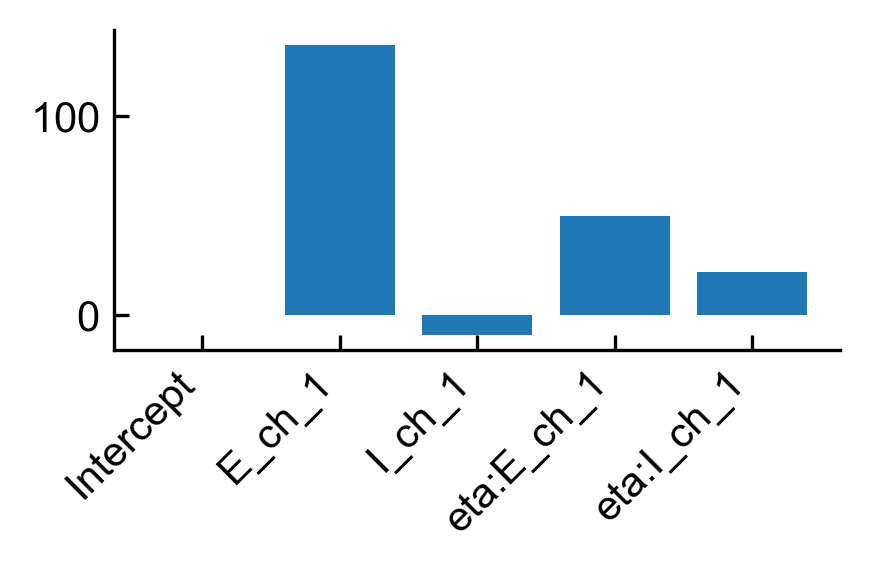

In [179]:
st_second_order_model_no_tr = "st_r ~ eta*(E_ch_1 + I_ch_1) - eta"

st_c_eta = smf.ols(st_second_order_model_no_tr, data=df_out).fit()
print(st_c_eta.summary()) 

params = dict(st_c_eta.params)
names = params.keys()
values = params.values()

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(range(len(params)), values)

ax.set_xticks(range(len(params)))
_ = ax.set_xticklabels(names, rotation=45, ha='right')

                            OLS Regression Results                            
Dep. Variable:                   ch_r   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:50:09   Log-Likelihood:                -17122.
No. Observations:               14400   AIC:                         3.425e+04
Df Residuals:                   14395   BIC:                         3.429e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8995      0.026    -34.864      0.0

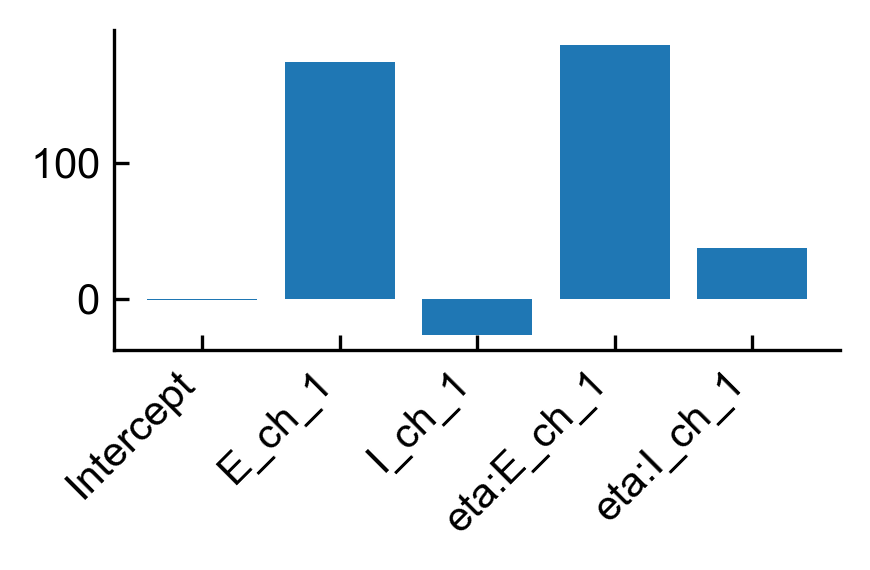

In [181]:
ch_second_order_model_no_tr = "ch_r ~ eta*(E_ch_1 + I_ch_1) - eta"

ch_c_eta = smf.ols(ch_second_order_model_no_tr, data=df_out).fit()
print(ch_c_eta.summary()) 

params = dict(ch_c_eta.params)
names = params.keys()
values = params.values()

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(range(len(params)), values)

ax.set_xticks(range(len(params)))
_ = ax.set_xticklabels(names, rotation=45, ha='right')

#### Training controls

In [183]:
df_out_shuf = df_out.copy()

st_r = np.array(df_out_shuf["st_r"])
np.random.shuffle(st_r)
df_out_shuf["st_r"] = st_r

ch_r = np.array(df_out_shuf["ch_r"])
np.random.shuffle(ch_r)
df_out_shuf["ch_r"] = ch_r

                            OLS Regression Results                            
Dep. Variable:                   st_r   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.311
Date:                Tue, 05 Apr 2022   Prob (F-statistic):              0.263
Time:                        15:50:19   Log-Likelihood:                -17960.
No. Observations:               14400   AIC:                         3.593e+04
Df Residuals:                   14395   BIC:                         3.597e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0504      0.027     38.410      0.0

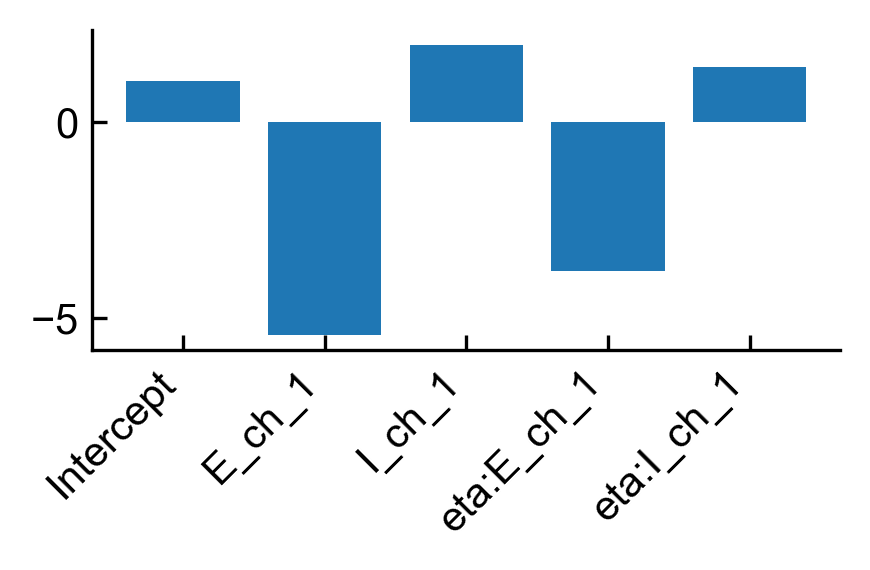

In [184]:
st_second_order_model_no_tr = "st_r ~ eta*(E_ch_1 + I_ch_1) - eta"

st_c_eta_shuf = smf.ols(st_second_order_model_no_tr, data=df_out_shuf).fit()
print(st_c_eta_shuf.summary()) 

params = dict(st_c_eta_shuf.params)
names = params.keys()
values = params.values()

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(range(len(params)), values)

ax.set_xticks(range(len(params)))
_ = ax.set_xticklabels(names, rotation=45, ha='right')

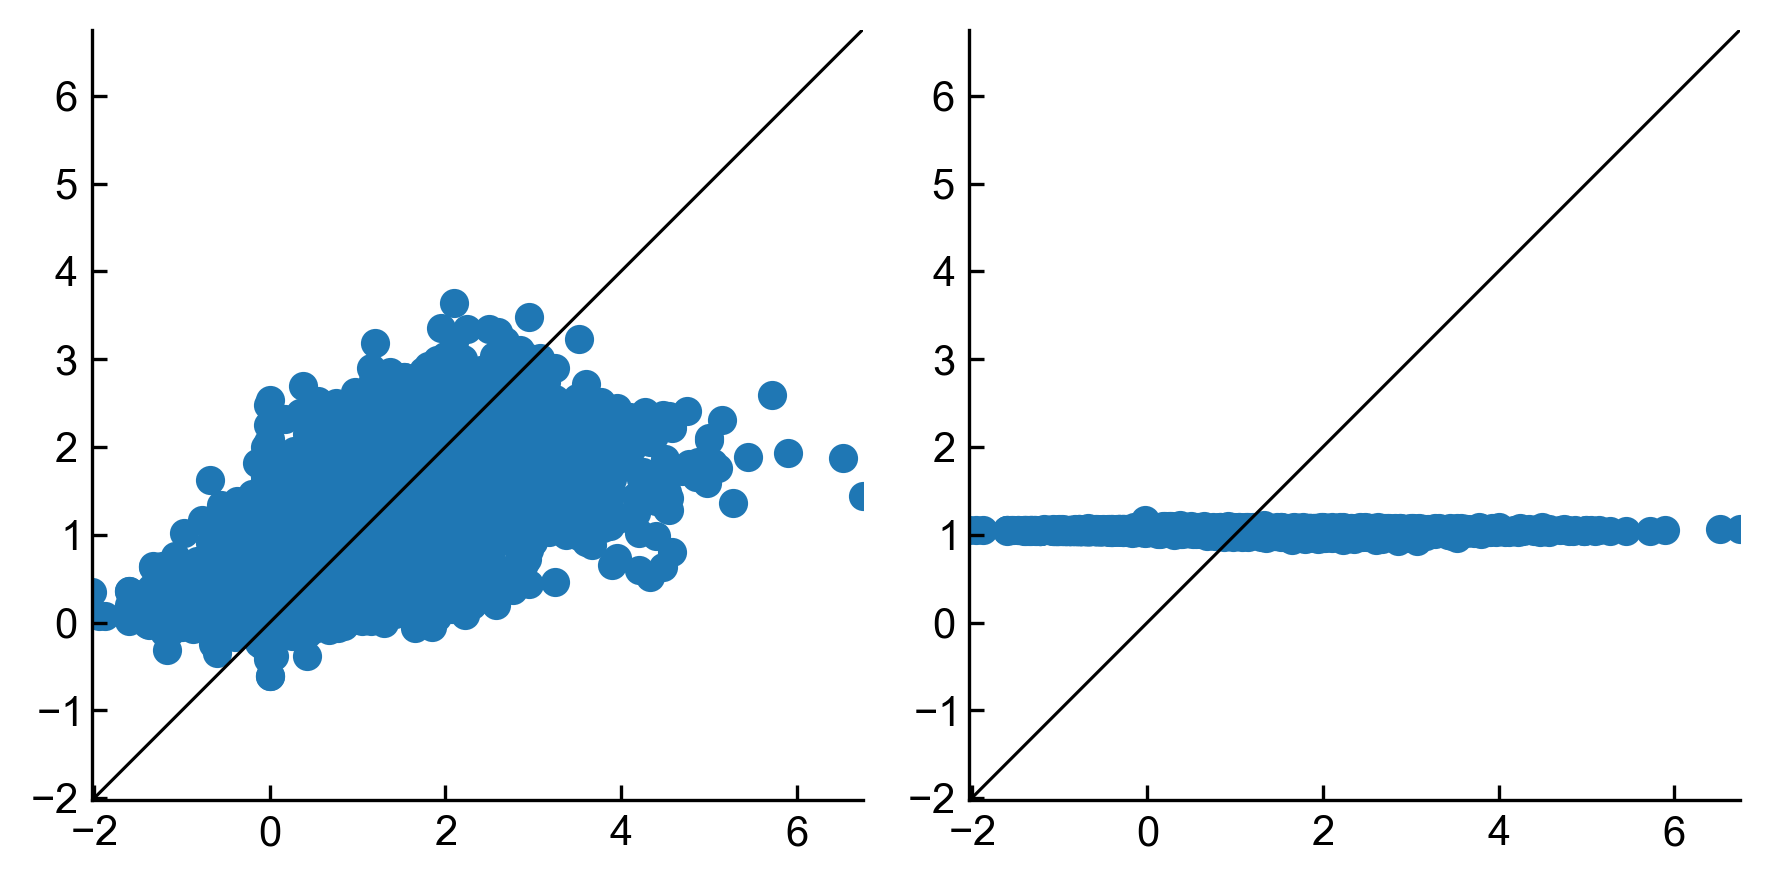

In [185]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))
max_val = np.max([np.array(df_out["st_r"]), st_c_eta.predict(df_out), st_c_eta_shuf.predict(df_out)]) 
min_val = np.min([np.array(df_out["st_r"]), st_c_eta.predict(df_out), st_c_eta_shuf.predict(df_out)]) 
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.plot([min_val, max_val], [min_val, max_val], color='k', lw=.75)
ax1.scatter(df_out["st_r"], st_c_eta.predict(df_out))
ax2.scatter(df_out["st_r"], st_c_eta_shuf.predict(df_out))

                            OLS Regression Results                            
Dep. Variable:                   ch_r   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.123
Date:                Tue, 05 Apr 2022   Prob (F-statistic):              0.343
Time:                        15:50:24   Log-Likelihood:                -27548.
No. Observations:               14400   AIC:                         5.511e+04
Df Residuals:                   14395   BIC:                         5.514e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1859      0.053      3.493      0.0

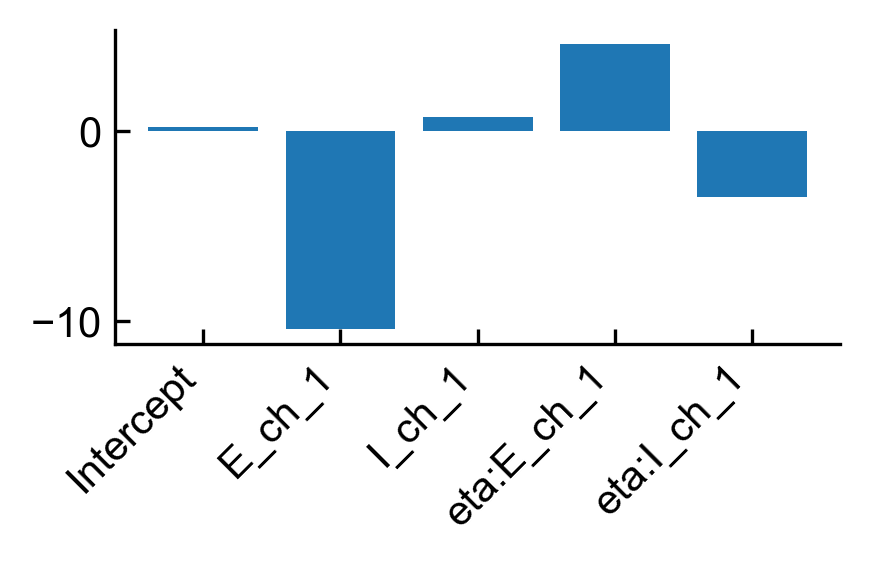

In [187]:
ch_second_order_model_no_tr = "ch_r ~ eta*(E_ch_1 + I_ch_1) - eta"

ch_c_eta_shuf = smf.ols(ch_second_order_model_no_tr, data=df_out_shuf).fit()
print(ch_c_eta_shuf.summary()) 

params = dict(ch_c_eta_shuf.params)
names = params.keys()
values = params.values()

fig, ax = plt.subplots(figsize=(3,2))
ax.bar(range(len(params)), values)

ax.set_xticks(range(len(params)))
_ = ax.set_xticklabels(names, rotation=45, ha='right')

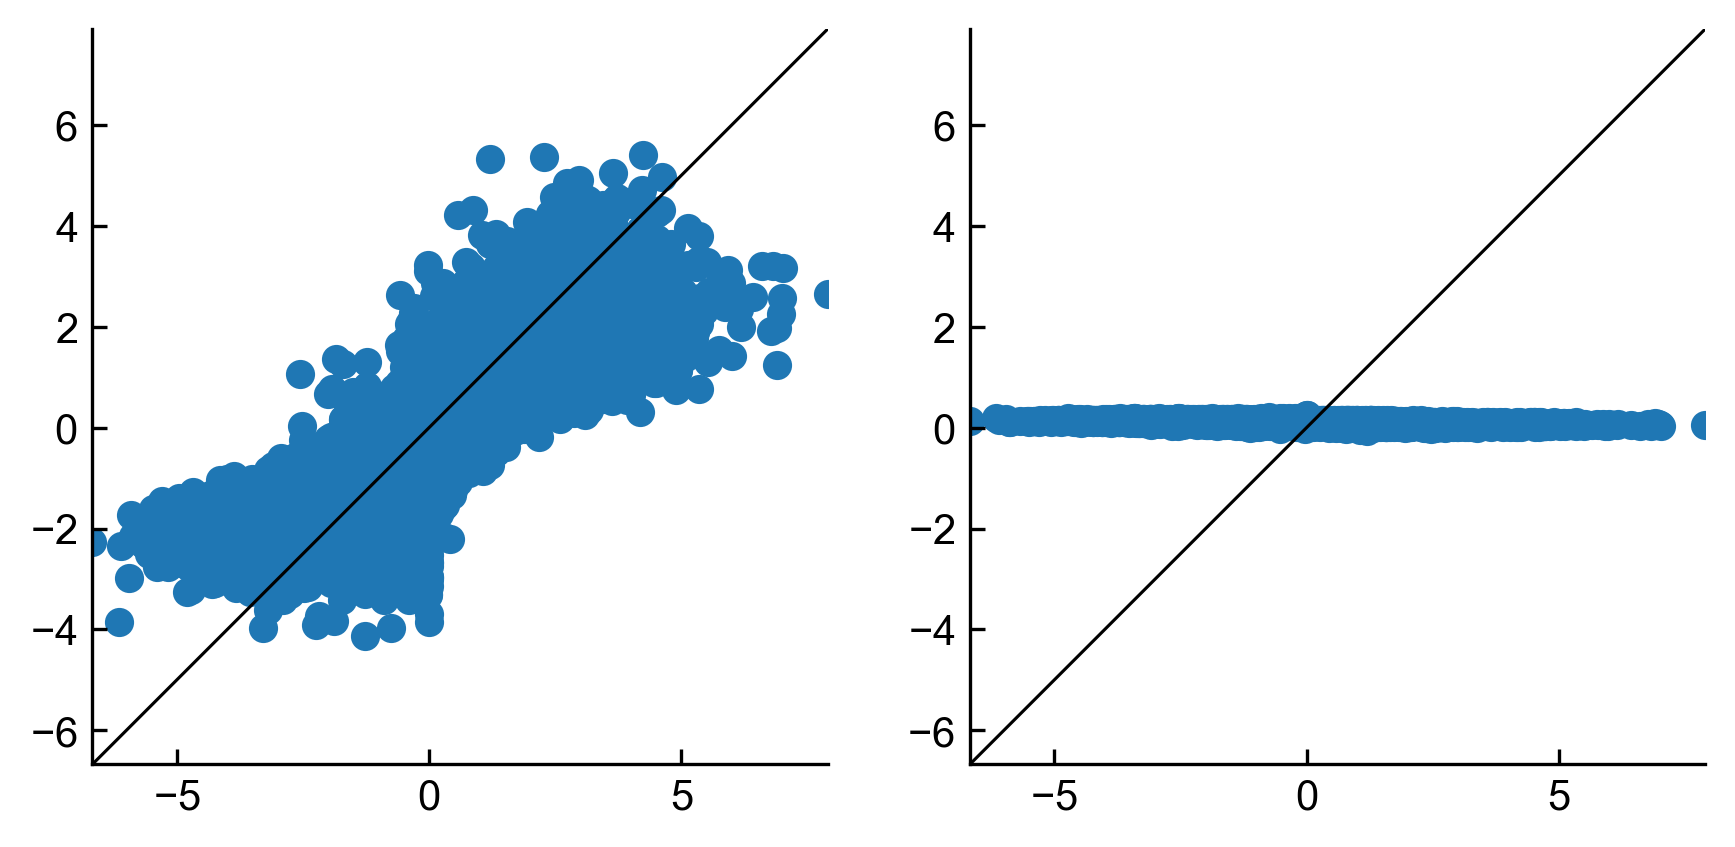

In [188]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))
max_val = np.max([np.array(df_out["ch_r"]), ch_c_eta.predict(df_out), ch_c_eta_shuf.predict(df_out)]) 
min_val = np.min([np.array(df_out["ch_r"]), ch_c_eta.predict(df_out), ch_c_eta_shuf.predict(df_out)]) 
for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.plot([min_val, max_val], [min_val, max_val], color='k', lw=.75)
ax1.scatter(df_out["ch_r"], ch_c_eta.predict(df_out))
ax2.scatter(df_out["ch_r"], ch_c_eta_shuf.predict(df_out))

## Analysis 

In [56]:
SAVE = True

DIR = "../results_experiments/whole_cell/"
MASTER_LIST = "MNI master list BFA edit.xlsx"
N = 2000
T = 150

C = 2.0
R = None
C_default = 2.0
R_default = 10.0
RMP = -60
THRESH = -30

G_SCALE = 1.0
SCALE_NOISE = False
NOISE = 0.3
METHOD = 'random'
PRIOR_SCALE = 2
NOISE_FUNC = sample_path

# Generating table of recordings
cell_df = pd.read_excel(os.path.join(WC_DIR, MASTER_LIST), usecols=range(21), engine='openpyxl', nrows=104)
cell_df['date'] = cell_df['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

### Establishing ground truth

In [58]:
# DOES NOT RUN - results provided below. 

# Looping over recordings
results = {}
spiking_outputs = {}
for animal_id, rec_id in tqdm(rec_spikes.items()):
    print(f"\nAnimal ID: {animal_id}")

    # Simulating
    try:
        data_df = load_exc_and_inh(rec_spikes[animal_id]['exc'], rec_spikes[animal_id]['inh'], drop_missing=True, R_default=R_default, C_default=C_default)
    except:
        print(f"Missing!")
        continue

    if animal_id[1][:2] == 'kk':
        R = 2.0
        C = 2.0
    elif animal_id[1][:2] == 'mn':
        R = None
        C = 2.0

    ps_pre, psl_pre, V_pre, g_pre = simulate_neuron(data_df, T=T, t_refrac=5, period='pre', noise=NOISE, scale_noise=SCALE_NOISE, noise_func=NOISE_FUNC, record_g=True, selection_method=METHOD, prior_scale=PRIOR_SCALE, N=N, C=C, R=R, threshold=THRESH)
    ps_post, psl_post, V_post, g_post = simulate_neuron(data_df, T=T, t_refrac=5, period='post', noise=NOISE, scale_noise=SCALE_NOISE, noise_func=NOISE_FUNC, record_g=True, selection_method=METHOD, prior_scale=PRIOR_SCALE, N=N, C=C, R=R, threshold=THRESH)
    baseline_firing_rate = ps_pre.sum(axis=1).mean() # * 1000 / T
    change_in_firing = (ps_post.sum(axis=1) - ps_pre.sum(axis=1)) 
    mean_change_in_firing = change_in_firing.mean() # * 1000 / T
    p_value = np.sum(np.abs(change_in_firing) > 2) / N


    # Actual modulation
    actual_baseline_firing_rate = calculate_baseline_firing_rate(rec_spikes[animal_id]['spikes'])
    actual_change_in_firing = calculate_stimulus_modulation(rec_spikes[animal_id]['spikes'])

    # Storing results
    print(f"Simulation:\t{baseline_firing_rate:.2f}, {mean_change_in_firing:.2f}\nActual:\t\t{actual_baseline_firing_rate:.2f}, {actual_change_in_firing:.2f}")
    results[animal_id] = {"st_actual": actual_change_in_firing,
                          "st_sim": mean_change_in_firing,
                          "fr_actual": actual_baseline_firing_rate,
                          "fr_sim": baseline_firing_rate, 
                          "NCR_p": p_value}
    

    ps = np.hstack([ps_pre[:, 0:100], ps_post])
    spiking_outputs[animal_id] = ps

# Formatting results     
gt_results_df = pd.DataFrame(results).swapaxes(0, 1)
gt_results_df

  0%|          | 0/5 [00:00<?, ?it/s]


Animal ID: ('2020-01-24', 'mni13', 3)
Processing exc. 20124009
Processing exc. 20124011
Processing inh. 20124010
Processing inh. 20124012
Processing inh. 20124013
Simulating pre w/ C = 2.0, R = 10.11, (R_s = 0.0192, R_in = 10.13), tau = 20.23
Simulating post w/ C = 2.0, R = 10.11, (R_s = 0.0192, R_in = 10.13), tau = 20.23


 20%|██        | 1/5 [00:13<00:55, 13.81s/it]

Simulation:	1.25, 1.96
Actual:		1.60, 3.60

Animal ID: ('2020-01-25', 'mni13', 2)
Processing exc. 20125002
Processing exc. 20125003
Processing exc. 20125005
Processing exc. 20125006
Processing exc. 20125008
Processing exc. 20125009
Processing exc. 20125010
Processing inh. 20125004
Processing inh. 20125007
Simulating pre w/ C = 2.0, R = 18.23, (R_s = 0.07047, R_in = 18.31), tau = 36.47
Simulating post w/ C = 2.0, R = 18.23, (R_s = 0.07047, R_in = 18.31), tau = 36.47


 40%|████      | 2/5 [00:29<00:45, 15.11s/it]

Simulation:	2.06, 1.23
Actual:		0.80, 0.40

Animal ID: ('2020-02-13', 'kkjg20', 2)
Processing exc. 14n11003e
Processing inh. 14n11003i
Simulating pre w/ C = 2.0, R = 2.0, (R_s = 0.0, R_in = 0.0), tau = 4.0
Simulating post w/ C = 2.0, R = 2.0, (R_s = 0.0, R_in = 0.0), tau = 4.0


 60%|██████    | 3/5 [00:42<00:27, 13.78s/it]

Simulation:	2.71, 4.95
Actual:		1.50, 4.33

Animal ID: ('2020-02-13', 'kkjg20', 3)
Processing exc. 14n11007e
Processing inh. 14n11007i
Simulating pre w/ C = 2.0, R = 2.0, (R_s = 0.0, R_in = 0.0), tau = 4.0
Simulating post w/ C = 2.0, R = 2.0, (R_s = 0.0, R_in = 0.0), tau = 4.0


 80%|████████  | 4/5 [00:53<00:12, 12.99s/it]

Simulation:	1.70, 14.42
Actual:		0.60, 3.00

Animal ID: ('2020-02-13', 'mni14', 1)
Processing exc. 20213001
Processing exc. 20213002
Processing exc. 20213005
Processing inh. 20213006
Simulating pre w/ C = 2.0, R = 14.0, (R_s = 0.1786, R_in = 14.18), tau = 28.0
Simulating post w/ C = 2.0, R = 14.0, (R_s = 0.1786, R_in = 14.18), tau = 28.0


100%|██████████| 5/5 [01:07<00:00, 13.55s/it]

Simulation:	1.57, 0.49
Actual:		1.93, 0.27


st_actual   st_sim  fr_actual  fr_sim   NCR_p
2020-01-24 mni13  3   3.600000   1.9600   1.600000  1.2535  0.4630
2020-01-25 mni13  2   0.400000   1.2255   0.800000  2.0575  0.4500
2020-02-13 kkjg20 2   4.333333   4.9475   1.500000  2.7060  0.8255
                  3   3.000000  14.4215   0.600000  1.7010  0.9525
           mni14  1   0.266667   0.4935   1.933333  1.5740  0.3205

In [80]:
gt_results_df = pd.read_csv(os.path.join(".", "data", "mouse", "simulation_ground_truth_comparison_2022-04-12-152901.csv", index_col=[0,1,2]))
gt_results_df


st_actual   st_sim  fr_actual  fr_sim   NCR_p
2020-01-24 mni13  3   3.600000   1.9565   1.600000  1.2085  0.4335
2020-01-25 mni13  2   0.400000   1.2735   0.800000  1.9435  0.4530
2020-02-13 kkjg20 2   4.333333   4.5370   1.500000  2.9140  0.8210
                  3   3.000000  14.3260   0.600000  1.8420  0.9500
           mni14  1   0.266667   0.4850   1.933333  1.5285  0.3100

MSE = 0.9425025272586218, Pearson r = 0.8600252424369328


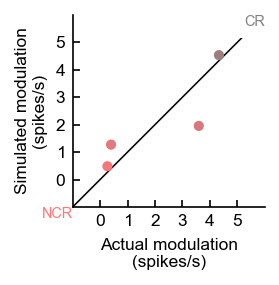

In [92]:
fig, ax, lim = make_NCR_prediction_scatter(sub_df["st_actual"],  sub_df["st_sim"], tick_steps=1, xlabel="Actual modulation\n(spikes/s)", ylabel="Simulated modulation\n(spikes/s)")

if SAVE:
    now = dt.datetime.now().strftime('%Y-%m-%d-%H%M%S')
    fig.savefig(f"../results_experiments/whole_cell/ground_truth_mod_comparison_{now}.pdf")


### Comparing simulations to recorded distribution

In [4]:
results_df = pd.read_csv(os.path.join(".", "data", "mouse", "whole_cell_simulations_2022-04-12-154049.csv", index_col=[0, 1, 2]))
results_df

st_pred   ch_pred  st_pred_shuf  ch_pred_shuf   st_sim  \
2020-01-24 mni13  1  3.852768  1.485235      1.179632     -0.112104   4.2400   
                  3  1.562492  0.636431      1.037490      0.067274   1.9055   
                  4  3.155619  2.732637      0.968211     -0.055208   0.1050   
2020-01-25 mni13  2  1.269090  0.368486      1.037060      0.090011   1.2790   
2020-02-12 mni14  2  1.587628 -0.020173      1.113415      0.064291   0.3555   
2020-02-13 kk106  1  4.742405 -3.458925      1.823792     -0.189818   8.0160   
                  2  4.690602  3.167646      1.078427     -0.175635   4.0755   
           kkjg20 1  7.067059  5.474886      1.066616     -0.359590   6.6545   
                  2  3.340704  0.518805      1.234582     -0.073182   5.2455   
                  3  8.510024  8.449668      0.883690     -0.468887  14.3405   
                  4       NaN       NaN           NaN           NaN   0.0000   
                  5  1.150489 -1.571121      1.241392      0.096412   1.3910   
                  6       NaN       NaN           NaN           NaN   0.0000   
           mni14  1  0.677043 -0.436239      1.065678      0.135490   0.3740   

                     st_sim_rescale   NCR_p     R_pred  R_pred_shuf  
2020-01-24 mni13  1          1.5850  0.6505   4.129133     1.184947  
                  3          0.3275  0.4420   1.687135     1.039669  
                  4         -0.1195  0.4105   4.174355     0.969784  
2020-01-25 mni13  2          0.2280  0.4465   1.321503     1.040959  
2020-02-12 mni14  2          0.0530  0.2615   1.587756     1.115270  
2020-02-13 kk106  1          1.7320  0.6555   5.869801     1.833643  
                  2          0.5255  0.7515   5.660012     1.092635  
           kkjg20 1          0.7200  0.7490   8.939670     1.125600  
                  2          2.3640  0.8365   3.380749     1.236749  
                  3          4.2350  0.9485  11.992390     1.000382  
                  4          0.0000  0.0000        NaN          NaN  
                  5          0.0410  0.1350   1.947318     1.245130  
                  6          0.0000  0.0000        NaN          NaN  
           mni14  1          0.0450  0.3265   0.805414     1.074257

In [5]:
MOUSE_STATISTICS_FILE = os.path.join(".", "data", "mouse", "mouse_neuron_statistics.csv")
mouse_resp_df = pd.read_csv(MOUSE_STATISTICS_FILE, index_col=0)
mouse_resp_df

,date,animal,cell_num,stim_time,R_st,R_ch,R,frac_1,frac_3,n_spikes_avg
0,2019-08-21,mni04,1,100.0,-2.400000,0.200000,2.408319,0.840000,0.440000,4.760000
1,2019-08-22,mni04,1,100.0,-2.400000,0.400000,2.433105,0.840000,0.440000,5.000000
2,2019-08-23,mni04,1,100.0,-0.222222,2.666667,2.675910,0.866667,0.633333,6.566667
3,2019-08-26,mni05,2,100.0,3.484848,8.409091,9.102581,0.727273,0.500000,9.863636
4,2019-08-27,mni05,1,100.0,2.266667,0.800000,2.403701,0.800000,0.560000,4.560000
5,2019-08-27,mni05,2,100.0,-2.366667,-0.100000,2.368778,0.980000,0.920000,9.800000
6,2019-08-27,mni05,3,100.0,1.333333,0.600000,1.462114,0.920000,0.640000,3.600000
7,2019-10-01,mni06,2,500.0,0.160494,0.222222,0.274119,0.181481,0.044444,0.381481
8,2019-10-03,mni07,1,100.0,5.466667,-1.100000,5.576239,0.980000,0.980000,37.460000
9,2019-10-03,mni07,2,100.0,-0.133333,-0.200000,0.240370,0.220000,0.000000,0.280000


In [188]:
def compare_distributions(A, B, figsize=(2, 2)):
    fig, ax = plt.subplots(figsize=figsize)
    A = A.dropna()
    B = B.dropna()

    X = np.hstack([[0], np.sort(A), [50]])
    Y = np.arange(0, len(X)) / (len(X) - 2)
    ax.step(X, Y, color='k', where='post', lw=.75, label="Recorded")

    X = np.hstack([[0], np.sort(B), [50]])
    Y = np.arange(0, len(X)) / (len(X)-2)
    ax.step(X, Y, color='.6', where='post', lw=.75, label="Simulated")

    ax.set_xlim(-.5, 10)
    ax.set_ylim(-.17, 1)
    ax.set_yticks([0, .5, 1])
    ax.set_yticklabels(["0%", "50%", "100%"], size="small")
    ax.set_xticklabels([-5, 0, 5, 10], size="small")
    ax.set_xlabel("Firing rate modulation\n(spikes/s)")
    ax.set_ylabel("Percent neurons")
    ax.text(0, -.14, "NCR", ha = "left", va="bottom", color=NNR_COLOR)
    ax.text(10, -.14, "CR", ha = "right", va="bottom", color=R_COLOR)
    ax.legend(labelspacing=.1, bbox_to_anchor=(0.0, 0.1, 1.0, 1.0))
    fig.tight_layout()
    return fig, ax



KstestResult(statistic=0.2672811059907834, pvalue=0.41284717368332824)


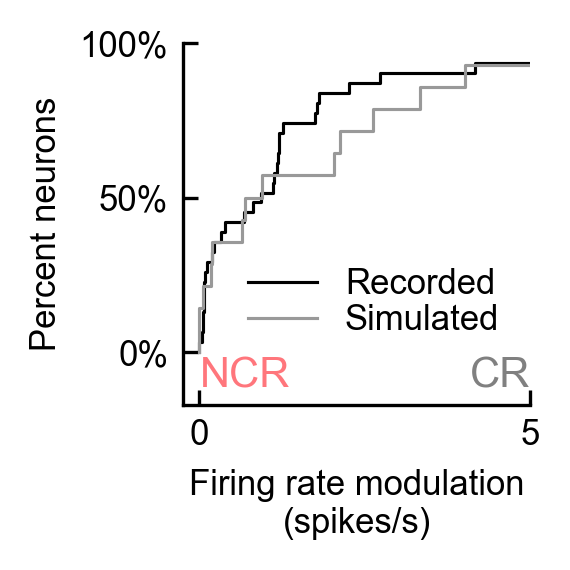

In [189]:
A = np.abs(mouse_resp_df["R_st"])
B = results_df["st_sim"].dropna()

fig, ax = compare_distributions(A, B) 
fig.savefig("../results_experiments/whole_cell/recorded_vs_simulated_distributions_0.pdf")
print(sps.kstest(A, B))


In [86]:
def make_NCR_prediction_scatter(X, Y, lim=None, xlabel="Predicted modulation\n(spikes/s)", ylabel="Firing rate modulation\n(spikes/s)", tick_steps=5):
    NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NNR_COLOR, R_COLOR], N=1000)
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_aspect('equal')
    
    if lim is None:
        min_val = int(np.floor(np.min([X, Y]))) - 1
        max_val = int(np.ceil(np.max([X, Y]))) + 1
    else:
        min_val, max_val = lim

    ax.scatter(X, Y, zorder=1, color=NCR_CR_cmap(list(sub_df["st_sim"]/6)), s=15)
    ax.plot([min_val, max_val], [min_val, max_val], color='k', lw=.75, zorder=0)
    ticks = range(0, max_val, tick_steps)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks, size="small")
    ax.set_yticklabels(ticks, size="small")
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel(xlabel, size="small")
    ax.set_ylabel(ylabel, size="small")
    ax.text(min_val, min_val, "NCR", ha = "right", va="top", color=NNR_COLOR, size="x-small")
    ax.text(max_val, max_val, "CR", ha = "right", va="top", color=R_COLOR, size="x-small", backgroundcolor='white')
    fig.tight_layout()

    MSE = np.sqrt(np.mean((Y - X)**2))
    a = np.array(Y, dtype="float")
    b = np.array(X, dtype="float")
    r = np.corrcoef(a, b)[1,0]
    print(f"MSE = {MSE}, Pearson r = {r}")


    return fig, ax, (min_val, max_val)

MSE = 2.2384792858120255, Pearson r = 0.8916423643291266


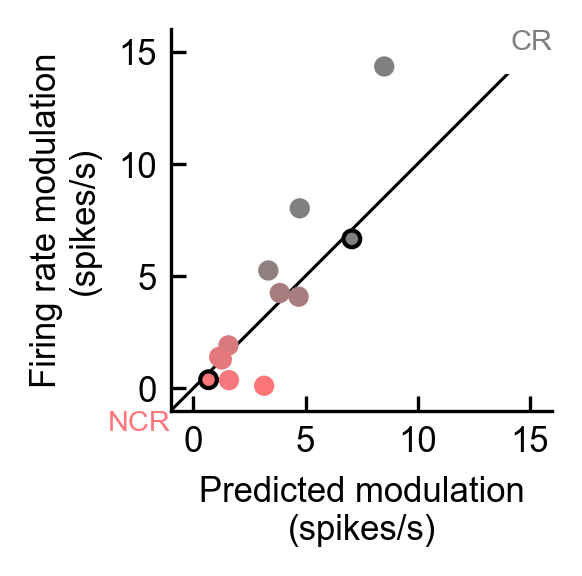

In [26]:
LABEL = [("2020-02-13", "kkjg20", 1), ("2020-02-13", "mni14", 1)]
X = sub_df["st_pred"].loc[LABEL]
Y = sub_df["st_sim"].loc[LABEL]

fig, ax, lim = make_NCR_prediction_scatter(sub_df["st_pred"], sub_df["st_sim"])
ax.scatter(X, Y, c="None", edgecolor='k', marker="o", s=16)

if SAVE:
    now = dt.datetime.now().strftime('%Y-%m-%d-%H%M%S')
    fig.savefig(f"../results_experiments/whole_cell/predicted_vs_actual_{now}.pdf")

MSE = 4.89661218199107, Pearson r = 0.11822191416078115


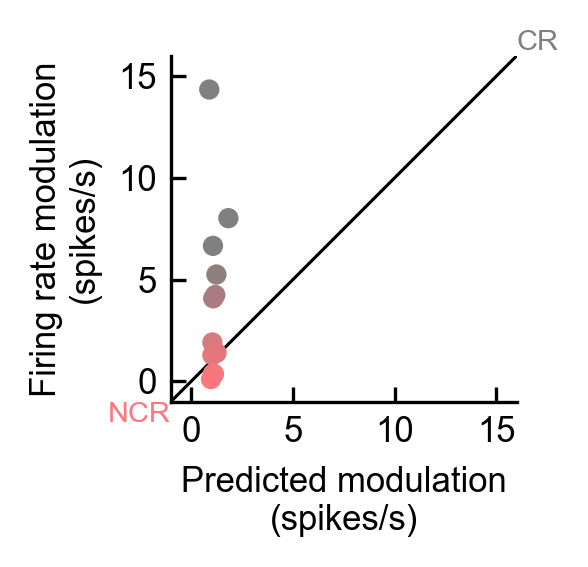

In [48]:
fig, ax, _ = make_NCR_prediction_scatter(sub_df["st_pred_shuf"], sub_df["st_sim"], lim=lim)

if SAVE:
    now = dt.datetime.now().strftime('%Y-%m-%d-%H%M%S')
    fig.savefig(f"../results_experiments/whole_cell/predicted_vs_actual_shuffled_{now}.pdf")

In [108]:
np.sqrt(0.11822191416078115)

0.34383413757330894

MSE = 3.0054025345098703, Pearson r = 0.7299290298449729


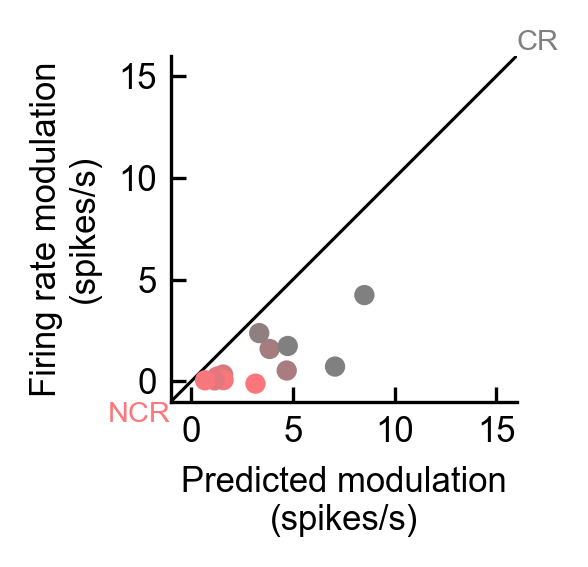

In [49]:
fig, ax, _ = make_NCR_prediction_scatter(sub_df["st_pred"], sub_df["st_sim_rescale"], lim=lim)

if SAVE:
    now = dt.datetime.now().strftime('%Y-%m-%d-%H%M%S')
    fig.savefig(f"../results_experiments/whole_cell/predicted_vs_actual_rescaled_{now}.pdf")